In [ ]:
# 测试环境
%run env.py
env = CombinatorialAuctionEnv(n_agents=5, n_items=3, max_steps=5)
obs = env.reset()
print("环境重置成功!")
print(f"观察: {obs}")
print(f"观察形状: {[o.shape for o in obs]}")

# 测试一步执5
actions = [env.action_space.sample() for _ in range(env.n_agents)]
print(f"随机动作: {actions}")

next_obs, rewards, done, info = env.step(actions)
print(f"执行成功! 奖励: {rewards}, 完成: {done}")
env.render()


In [ ]:
# 测试 MADDPG
%run maddpg.py

# 使用与环境相同的参数
n_agents = 5
obs_dims = [env.obs_dim] * n_agents  # 注意使用 env.obs_dim 而不是 env.n_items
act_dims = [env.n_items] * n_agents

maddpg = MADDPG(n_agents, obs_dims, act_dims)
print("MADDPG 初始化成功!")

# 测试动作生成
test_obs = env.reset()
# 环境的reset()已经返回了正确的格式，不需要再处理
test_actions = maddpg.act(test_obs)
print(f"MADDPG 生成的动作: {test_actions}")


In [ ]:
# 简化训练循环
import numpy as np

# 重置环境
obs_list = env.reset()
done = False
episode_reward = 0

step_rewards = []        # 每一步的总奖励
cumulative_rewards = []  # 每一步的累计总奖励

while not done:
    # 使用 MADDPG 生成动作
    actions = maddpg.act(obs_list)
    
    # 执行动作
    next_obs_list, rewards, done, info = env.step(actions)
    
    step_total = np.sum(rewards)
    episode_reward += step_total
    
    step_rewards.append(step_total)
    cumulative_rewards.append(episode_reward)
    
    # 存储经验 - 使用store_transition方法
    maddpg.store_transition(obs_list, actions, rewards, next_obs_list, done)
    
    # 更新观察
    obs_list = next_obs_list
    
    print(f"步骤奖励: {rewards}, 步骤总和: {step_total}, 累计奖励: {episode_reward}")

print(f"回合结束，总奖励: {episode_reward}")


# 尝试更新 MADDPG
print("尝试更新 MADDPG...")
maddpg.update(batch_size=32)
print("更新完成!")


In [ ]:
# 可视化 1：奖励曲线
import matplotlib.pyplot as plt

# 在 Jupyter 里用
%matplotlib inline

plt.figure()
plt.plot(step_rewards, marker='o')
plt.xlabel("Step")
plt.ylabel("Total Reward per Step")
plt.title("Per-step Total Reward")

plt.figure()
plt.plot(cumulative_rewards, marker='o')
plt.xlabel("Step")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward over Episode")

plt.show()


In [ ]:
# 可视化 2：每个智能体的效用曲线
import numpy as np
import matplotlib.pyplot as plt

utilities = np.array(env.history['utilities'])  # 形状: (T, n_agents)

print("utilities 形状:", utilities.shape)

plt.figure()
for i in range(env.n_agents):
    plt.plot(utilities[:, i], marker='o', label=f"Agent {i}")
plt.xlabel("Step")
plt.ylabel("Utility")
plt.title("Agent Utilities over Time")
plt.legend()
plt.show()


In [ ]:
# 可视化 3：每个智能体获得物品数量
import numpy as np
import matplotlib.pyplot as plt

# allocations: list of (n_agents, n_items) 的布尔矩阵
allocations = np.array(env.history['allocations'])  # 形状: (T, n_agents, n_items)

# 对时间和物品维度求和，得到每个智能体在整个回合获得的物品总数
items_per_agent = allocations.sum(axis=(0, 2))

print("items_per_agent:", items_per_agent)

plt.figure()
plt.bar(range(env.n_agents), items_per_agent)
plt.xlabel("Agent")
plt.ylabel("Total Items Won")
plt.title("Total Items Won per Agent in Episode")
plt.show()


In [ ]:
#check (这些应该都一样)
print("env.n_agents =", env.n_agents)
print("MADDPG n_agents =", maddpg.n_agents)  # 修正：使用 n_agents 而不是 n
print("len(test_obs) =", len(test_obs))
print("len(maddpg.actors) =", len(maddpg.actors))


In [ ]:
# 多回合训练测试
import numpy as np
import matplotlib.pyplot as plt

# 训练参数
n_episodes = 10
episode_rewards = []

for episode in range(n_episodes):
    # 重置环境
    obs_list = env.reset()
    done = False
    ep_reward = 0
    
    while not done:
        # 使用 MADDPG 生成动作
        actions = maddpg.act(obs_list, explore=True)  # 启用探索
        
        # 执行动作
        next_obs_list, rewards, done, info = env.step(actions)
        
        # 存储经验
        maddpg.store_transition(obs_list, actions, rewards, next_obs_list, done)
        
        # 更新观察
        obs_list = next_obs_list
        
        # 累计奖励
        ep_reward += np.sum(rewards)
    
    # 每回合结束后更新网络
    maddpg.update(batch_size=32)
    
    episode_rewards.append(ep_reward)
    print(f"回合 {episode+1}, 总奖励: {ep_reward:.2f}")

# 绘制训练曲线
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_episodes+1), episode_rewards, marker='o')
plt.xlabel("回合")
plt.ylabel("总奖励")
plt.title("MADDPG 训练曲线")
plt.grid(True)
plt.show()


In [ ]:
# 测试MADDPG的动作分布
import numpy as np
import matplotlib.pyplot as plt

# 收集多次动作样本
n_samples = 100
all_actions = []

obs_list = env.reset()
for _ in range(n_samples):
    actions = maddpg.act(obs_list, explore=True)
    all_actions.append(actions)

# 将动作转换为numpy数组便于分析
# 形状: (n_samples, n_agents, n_items)
action_array = np.array([[a[i] for i in range(env.n_agents)] for a in all_actions])

# 绘制每个智能体第一个物品的出价分布
plt.figure(figsize=(12, 8))
for i in range(env.n_agents):
    plt.subplot(env.n_agents, 1, i+1)
    plt.hist(action_array[:, i, 0], bins=20, alpha=0.7)
    plt.title(f"智能体 {i} 对物品0的出价分布")
    plt.xlabel("出价")
    plt.ylabel("频次")
    plt.grid(True)

plt.tight_layout()
plt.show()

# 计算每个智能体的平均出价
mean_bids = action_array.mean(axis=0)
print("每个智能体的平均出价:")
for i in range(env.n_agents):
    print(f"智能体 {i}: {mean_bids[i]}")


In [ ]:
# 测试模型保存和加载功能
import os
import torch

# 创建保存目录
save_dir = "./models"
os.makedirs(save_dir, exist_ok=True)

# 保存模型
def save_maddpg(maddpg, path):
    """保存MADDPG模型"""
    state = {
        'actors': [actor.state_dict() for actor in maddpg.actors],
        'critics': [critic.state_dict() for critic in maddpg.critics],
        'target_actors': [target.state_dict() for target in maddpg.target_actors],
        'target_critics': [target.state_dict() for target in maddpg.target_critics],
    }
    torch.save(state, path)
    print(f"模型已保存到 {path}")

# 加载模型
def load_maddpg(maddpg, path):
    """加载MADDPG模型"""
    if not os.path.exists(path):
        print(f"模型文件 {path} 不存在")
        return False
    
    state = torch.load(path)
    
    # 加载网络参数
    for i in range(maddpg.n_agents):  # 修正：使用 n_agents 而不是 n
        maddpg.actors[i].load_state_dict(state['actors'][i])
        maddpg.critics[i].load_state_dict(state['critics'][i])
        maddpg.target_actors[i].load_state_dict(state['target_actors'][i])
        maddpg.target_critics[i].load_state_dict(state['target_critics'][i])
    
    print(f"模型已从 {path} 加载")
    return True

# 保存当前模型
model_path = os.path.join(save_dir, "maddpg_test.pt")
save_maddpg(maddpg, model_path)

# 测试加载模型
load_maddpg(maddpg, model_path)

# 使用加载后的模型生成动作
test_obs = env.reset()
test_actions = maddpg.act(test_obs)
print(f"加载模型后生成的动作: {test_actions}")


In [23]:
# 测试环境
%run env.py
env = CombinatorialAuctionEnv(n_agents=5, n_items=3, max_steps=5)
obs = env.reset()
print("环境重置成功!")
print(f"观察: {obs}")
print(f"观察形状: {[o.shape for o in obs]}")

# 测试一步执5
actions = [env.action_space.sample() for _ in range(env.n_agents)]
print(f"随机动作: {actions}")

next_obs, rewards, done, info = env.step(actions)
print(f"执行成功! 奖励: {rewards}, 完成: {done}")
env.render()

环境重置成功!
观察: [array([5.7154372 , 7.90776882, 5.21426888, 0.        , 0.        ,
       0.        , 0.        ]), array([5.82260315, 8.91945751, 8.29239527, 0.        , 0.        ,
       0.        , 0.        ]), array([6.55078939, 4.38725454, 3.03657546, 0.        , 0.        ,
       0.        , 0.        ]), array([0.36401468, 2.31434714, 8.27858413, 0.        , 0.        ,
       0.        , 0.        ]), array([8.63160144, 4.82546204, 1.38175243, 0.        , 0.        ,
       0.        , 0.        ])]
观察形状: [(7,), (7,), (7,), (7,), (7,)]
随机动作: [array([9.183588 , 1.1224313, 9.1642885], dtype=float32), array([4.6123295 , 8.747184  , 0.49519548], dtype=float32), array([1.7119814, 7.07638  , 3.2563212], dtype=float32), array([2.2975323, 7.478889 , 5.326704 ], dtype=float32), array([8.491527  , 2.19674   , 0.26948854], dtype=float32)]
执行成功! 奖励: [-2.88852455  1.44056852  0.          0.          0.        ], 完成: False

=== 回合 1 ===
真实估值:
  智能体 0: [5.7154372  7.90776882 5.21426888]
  智能体

In [24]:
# 测试 MADDPG
%run maddpg.py

# 使用与环境相同的参数
n_agents = 5
obs_dims = [env.obs_dim] * n_agents  # 注意使用 env.obs_dim 而不是 env.n_items
act_dims = [env.n_items] * n_agents

maddpg = MADDPG(n_agents, obs_dims, act_dims)
print("MADDPG 初始化成功!")

# 测试动作生成
test_obs = env.reset()
# 环境的reset()已经返回了正确的格式，不需要再处理
test_actions = maddpg.act(test_obs)
print(f"MADDPG 生成的动作: {test_actions}")

C:\Users\pc\Desktop\comb\maddpg.py:20: SyntaxWarning: invalid escape sequence '\i'
  


MADDPG 初始化成功!
MADDPG 生成的动作: [array([0.44910684, 0.48469475, 0.4656736 ], dtype=float32), array([0.45692363, 0.5102832 , 0.5278677 ], dtype=float32), array([0.5480046 , 0.35114956, 0.43938968], dtype=float32), array([0.5614132 , 0.33139977, 0.45687756], dtype=float32), array([0.4126716 , 0.5372785 , 0.41814035], dtype=float32)]


In [25]:
# 简化训练循环
import numpy as np

# 重置环境
obs_list = env.reset()
done = False
episode_reward = 0

step_rewards = []        # 每一步的总奖励
cumulative_rewards = []  # 每一步的累计总奖励

while not done:
    # 使用 MADDPG 生成动作
    actions = maddpg.act(obs_list)
    
    # 执行动作
    next_obs_list, rewards, done, info = env.step(actions)
    
    step_total = np.sum(rewards)
    episode_reward += step_total
    
    step_rewards.append(step_total)
    cumulative_rewards.append(episode_reward)
    
    # 存储经验 - 使用store_transition方法
    maddpg.store_transition(obs_list, actions, rewards, next_obs_list, done)
    
    # 更新观察
    obs_list = next_obs_list
    
    print(f"步骤奖励: {rewards}, 步骤总和: {step_total}, 累计奖励: {episode_reward}")

print(f"回合结束，总奖励: {episode_reward}")


# 尝试更新 MADDPG
print("尝试更新 MADDPG...")
maddpg.update(batch_size=32)
print("更新完成!")

步骤奖励: [0.         7.22082592 8.07676509 0.         5.33635888], 步骤总和: 20.63394989777351, 累计奖励: 20.63394989777351
步骤奖励: [0.         7.22499655 8.07153044 0.         5.36229548], 步骤总和: 20.658822469003443, 累计奖励: 41.29277236677695
步骤奖励: [0.         7.22523929 8.07158146 0.         5.35966328], 步骤总和: 20.656484029777292, 累计奖励: 61.94925639655425
步骤奖励: [0.         7.22561337 8.07172856 0.         5.35736809], 步骤总和: 20.654710016734843, 累计奖励: 82.60396641328909
步骤奖励: [0.         7.22629918 8.0717431  0.         5.35500786], 步骤总和: 20.653050146587137, 累计奖励: 103.25701655987622
回合结束，总奖励: 103.25701655987622
尝试更新 MADDPG...
更新完成!


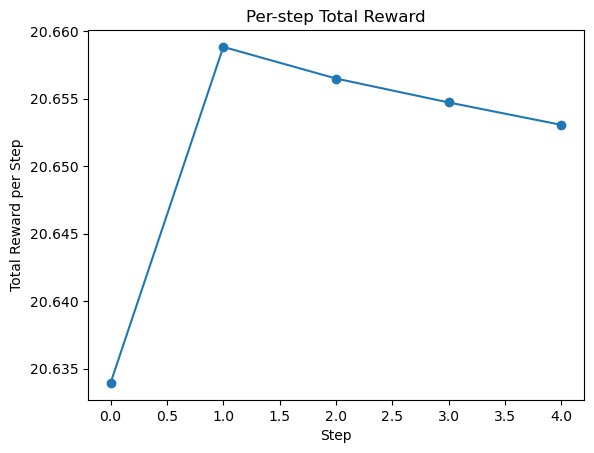

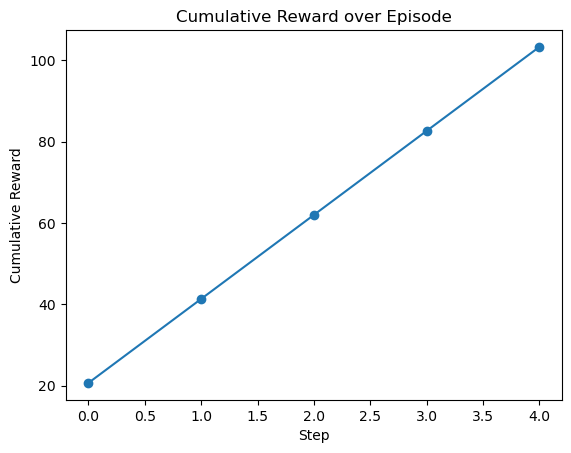

In [26]:
# 可视化 1：奖励曲线
import matplotlib.pyplot as plt

# 在 Jupyter 里用
%matplotlib inline

plt.figure()
plt.plot(step_rewards, marker='o')
plt.xlabel("Step")
plt.ylabel("Total Reward per Step")
plt.title("Per-step Total Reward")

plt.figure()
plt.plot(cumulative_rewards, marker='o')
plt.xlabel("Step")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward over Episode")

plt.show()


utilities 形状: (5, 5)


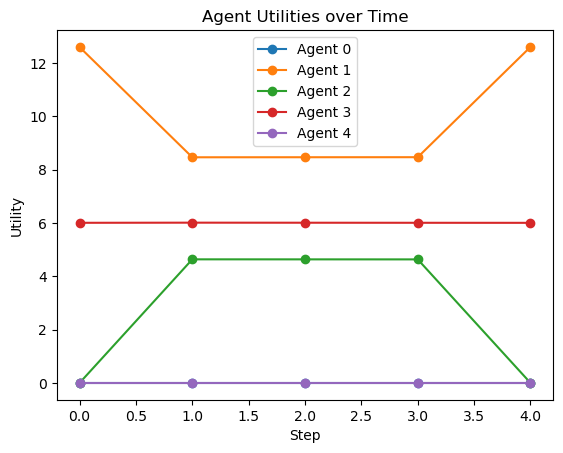

In [13]:
# 可视化 2：每个智能体的效用曲线
import numpy as np
import matplotlib.pyplot as plt

utilities = np.array(env.history['utilities'])  # 形状: (T, n_agents)

print("utilities 形状:", utilities.shape)

plt.figure()
for i in range(env.n_agents):
    plt.plot(utilities[:, i], marker='o', label=f"Agent {i}")
plt.xlabel("Step")
plt.ylabel("Utility")
plt.title("Agent Utilities over Time")
plt.legend()
plt.show()


items_per_agent: [0 5 5 0 5]


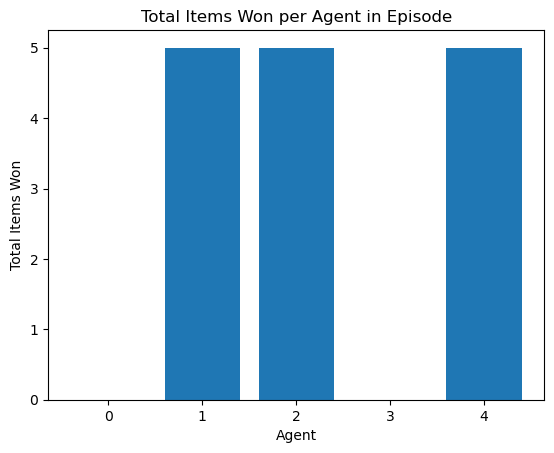

In [27]:
# 可视化 3：每个智能体获得物品数量
import numpy as np
import matplotlib.pyplot as plt

# allocations: list of (n_agents, n_items) 的布尔矩阵
allocations = np.array(env.history['allocations'])  # 形状: (T, n_agents, n_items)

# 对时间和物品维度求和，得到每个智能体在整个回合获得的物品总数
items_per_agent = allocations.sum(axis=(0, 2))

print("items_per_agent:", items_per_agent)

plt.figure()
plt.bar(range(env.n_agents), items_per_agent)
plt.xlabel("Agent")
plt.ylabel("Total Items Won")
plt.title("Total Items Won per Agent in Episode")
plt.show()


In [28]:
#check (这些应该都一样)
print("env.n_agents =", env.n_agents)
print("MADDPG n =", maddpg.n)
print("len(test_obs) =", len(test_obs))
print("len(maddpg.actors) =", len(maddpg.actors))


env.n_agents = 5


AttributeError: 'MADDPG' object has no attribute 'n'

回合 1, 总奖励: 66.04
回合 2, 总奖励: 35.37
回合 3, 总奖励: 84.56
回合 4, 总奖励: 43.17
回合 5, 总奖励: 77.31
回合 6, 总奖励: 42.88
回合 7, 总奖励: 40.16
回合 8, 总奖励: 80.86
回合 9, 总奖励: 59.13
回合 10, 总奖励: 44.58


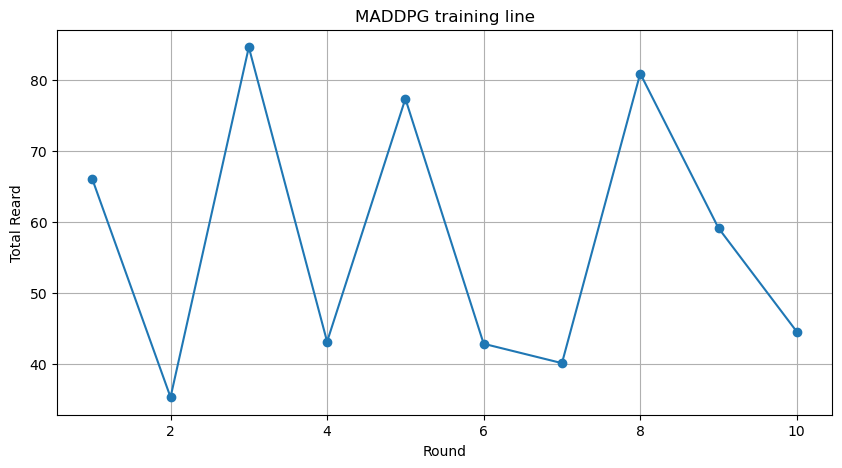

In [31]:
# 多回合训练测试
import numpy as np
import matplotlib.pyplot as plt

# 训练参数
n_episodes = 10
episode_rewards = []

for episode in range(n_episodes):
    # 重置环境
    obs_list = env.reset()
    done = False
    ep_reward = 0
    
    while not done:
        # 使用 MADDPG 生成动作
        actions = maddpg.act(obs_list, explore=True)  # 启用探索
        
        # 执行动作
        next_obs_list, rewards, done, info = env.step(actions)
        
        # 存储经验
        maddpg.store_transition(obs_list, actions, rewards, next_obs_list, done)
        
        # 更新观察
        obs_list = next_obs_list
        
        # 累计奖励
        ep_reward += np.sum(rewards)
    
    # 每回合结束后更新网络
    maddpg.update(batch_size=32)
    
    episode_rewards.append(ep_reward)
    print(f"回合 {episode+1}, 总奖励: {ep_reward:.2f}")

# 绘制训练曲线
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_episodes+1), episode_rewards, marker='o')
plt.xlabel("Round")
plt.ylabel("Total Reard")
plt.title("MADDPG training line")
plt.grid(True)
plt.show()


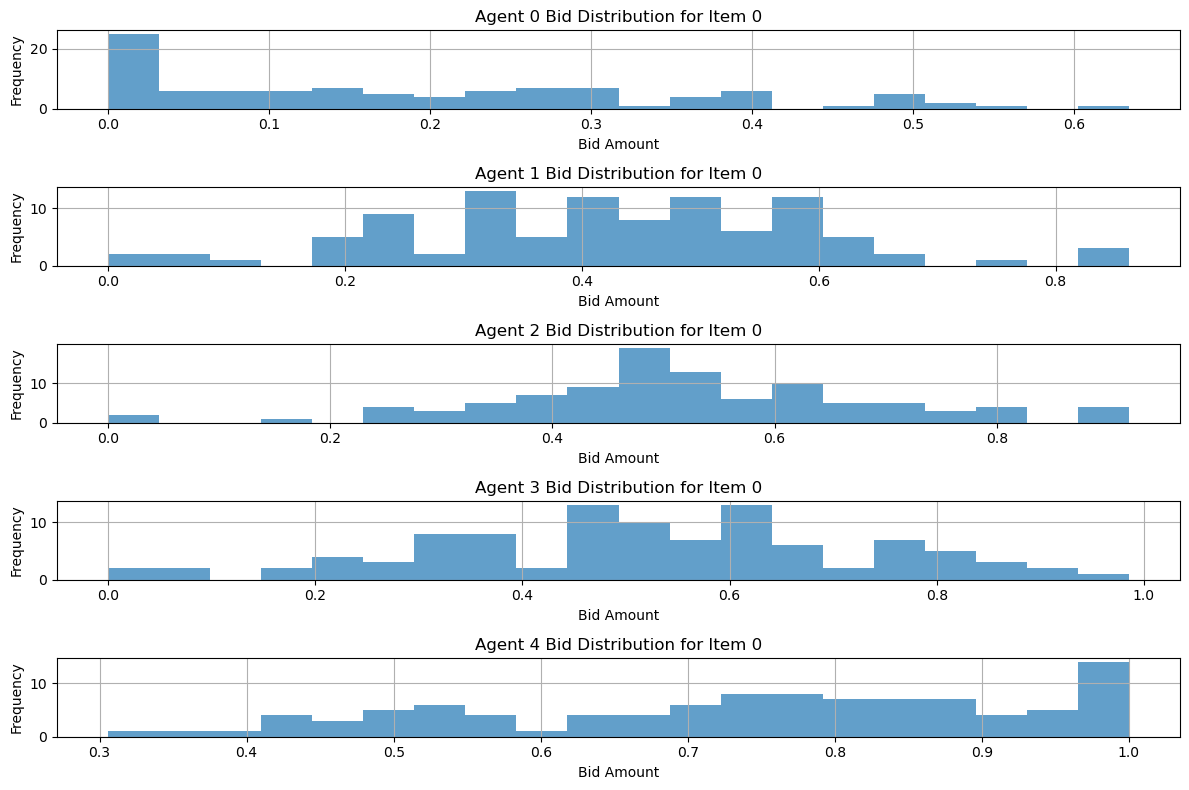

Average bids per agent:
Agent 0: [0.18927506 0.47797024 0.36012524]
Agent 1: [0.4222035  0.38919544 0.16844843]
Agent 2: [0.52023244 0.5745546  0.25037223]
Agent 3: [0.5179451 0.7306071 0.737285 ]
Agent 4: [0.7419754 0.4036919 0.5839464]


In [30]:
# 测试MADDPG的动作分布
import numpy as np
import matplotlib.pyplot as plt

# 收集多次动作样本
n_samples = 100
all_actions = []

obs_list = env.reset()
for _ in range(n_samples):
    actions = maddpg.act(obs_list, explore=True)
    all_actions.append(actions)

# 将动作转换为numpy数组便于分析
# 形状: (n_samples, n_agents, n_items)
action_array = np.array([[a[i] for i in range(env.n_agents)] for a in all_actions])

# 绘制每个智能体第一个物品的出价分布
plt.figure(figsize=(12, 8))
for i in range(env.n_agents):
    plt.subplot(env.n_agents, 1, i+1)
    plt.hist(action_array[:, i, 0], bins=20, alpha=0.7)
    # Translated title
    plt.title(f"Agent {i} Bid Distribution for Item 0")
    # Translated x-axis label
    plt.xlabel("Bid Amount")
    # Translated y-axis label
    plt.ylabel("Frequency")
    plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate average bids for each agent
mean_bids = action_array.mean(axis=0)
# Translated print statement
print("Average bids per agent:")
for i in range(env.n_agents):
    # Translated print statement
    print(f"Agent {i}: {mean_bids[i]}")


In [32]:
# 测试模型保存和加载功能
import os
import torch

# 创建保存目录
save_dir = "./models"
os.makedirs(save_dir, exist_ok=True)

# 保存模型
def save_maddpg(maddpg, path):
    """保存MADDPG模型"""
    state = {
        'actors': [actor.state_dict() for actor in maddpg.actors],
        'critics': [critic.state_dict() for critic in maddpg.critics],
        'target_actors': [target.state_dict() for target in maddpg.target_actors],
        'target_critics': [target.state_dict() for target in maddpg.target_critics],
    }
    torch.save(state, path)
    print(f"模型已保存到 {path}")

# 加载模型
def load_maddpg(maddpg, path):
    """加载MADDPG模型"""
    if not os.path.exists(path):
        print(f"模型文件 {path} 不存在")
        return False
    
    state = torch.load(path)
    
    # 加载网络参数
    for i in range(maddpg.n):
        maddpg.actors[i].load_state_dict(state['actors'][i])
        maddpg.critics[i].load_state_dict(state['critics'][i])
        maddpg.target_actors[i].load_state_dict(state['target_actors'][i])
        maddpg.target_critics[i].load_state_dict(state['target_critics'][i])
    
    print(f"模型已从 {path} 加载")
    return True

# 保存当前模型
model_path = os.path.join(save_dir, "maddpg_test.pt")
save_maddpg(maddpg, model_path)

# 测试加载模型
load_maddpg(maddpg, model_path)

# 使用加载后的模型生成动作
test_obs = env.reset()
test_actions = maddpg.act(test_obs)
print(f"加载模型后生成的动作: {test_actions}")


模型已保存到 ./models\maddpg_test.pt


AttributeError: 'MADDPG' object has no attribute 'n'